#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션4

* 단계별로 나눠서 모델링을 수행하고자 합니다.  
* 단계 구분 예시
    * 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
    * 단계2 : 세부 동작에 대한 분류모델 생성
        * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
        * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* (선택) 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 성능 가이드
        * Accuracy : 0.97 ~ 0.99
* (선택) 파이프라인 구성
    * test 데이터를 입력하여, 전처리 및 예측결과가 나오도록 함수 구성

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project1 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/project1_2/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩
  - pandas, numpy,matplotlib,seaborn, joblib, 모델링에 필요한 라이브러리를 로딩합니다.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
def set_random_seed(seed=42):
    """
    모든 라이브러리의 랜덤 시드를 고정하는 함수

    Parameters:
    seed (int): 시드 값 (기본값: 42)
    """
    # 1. Python 기본 random 모듈 시드 고정
    random.seed(seed)

    # 2. NumPy 시드 고정
    np.random.seed(seed)

    # 3. 환경변수로 시드 고정 (일부 라이브러리에서 사용)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # 4. PyTorch 시드 고정 (PyTorch 사용시)
    try:
        import torch
        torch.manual_seed(seed)

        # CUDA 사용시
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
    except ImportError:
        pass

    # 5. TensorFlow 시드 고정 (TensorFlow 사용시)
    try:
        import tensorflow as tf
        if hasattr(tf, 'random'):
            tf.random.set_seed(seed)
        else:
            tf.set_random_seed(seed)
    except ImportError:
        pass

    print(f"모든 랜덤 시드가 {seed}로 고정되었습니다.")

# 사용법
set_random_seed(42)

모든 랜덤 시드가 42로 고정되었습니다.


In [5]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [6]:
# 주어진 데이터 셋을 불러오세요.(3개)
train = pd.read_csv(path + 'data01_train.csv')
test = pd.read_csv(path + 'data01_test.csv')
features = pd.read_csv(path + 'features.csv')

In [7]:
#불필요한 칼럼을 삭제하세요.
train = train.drop('subject', axis = 1)
test = test.drop('subject', axis = 1)

#### 2) 기본 정보 조회

In [8]:
#전체 데이터의 행,열 개수 확인
print(train.shape)
print(test.shape)

(5881, 562)
(1471, 562)


In [9]:
#전체 데이터의 상위 5개 행 확인
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [10]:
test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


In [11]:
#전체 데이터의 수치형 변수 분포 확인
train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [12]:
test.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,...,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000
mean,0.273198,-0.017281,-0.108123,-0.614634,-0.515427,-0.607533,-0.639950,-0.530760,-0.609256,-0.481055,...,0.118651,-0.311513,-0.632273,0.009324,0.015666,0.006272,-0.001510,-0.481737,0.055771,-0.064194
std,0.079989,0.045957,0.049082,0.448480,0.506094,0.424243,0.422994,0.489381,0.418536,0.542756,...,0.258112,0.313792,0.296179,0.324864,0.452616,0.608954,0.483028,0.522714,0.298124,0.281645
min,-1.000000,-1.000000,-0.418354,-0.999717,-0.999873,-1.000000,-0.999867,-1.000000,-0.999879,-0.948723,...,-1.000000,-0.995357,-0.994664,-0.937468,-0.990492,-0.995222,-0.969066,-0.999380,-0.995073,-1.000000
25%,0.263787,-0.024792,-0.120733,-0.992669,-0.979082,-0.981070,-0.993498,-0.979214,-0.980659,-0.936791,...,-0.035193,-0.546342,-0.844547,-0.119166,-0.265533,-0.485998,-0.380300,-0.814060,-0.017413,-0.148445
50%,0.277322,-0.017187,-0.108124,-0.952426,-0.867309,-0.869890,-0.958705,-0.873891,-0.863451,-0.890491,...,0.135282,-0.347433,-0.706699,0.005049,0.023421,-0.005036,0.002408,-0.708911,0.178814,-0.002243
75%,0.288058,-0.010238,-0.096606,-0.245405,-0.030639,-0.260223,-0.297260,-0.058824,-0.256657,-0.030692,...,0.289832,-0.125796,-0.516910,0.135698,0.312690,0.518184,0.374583,-0.486534,0.248126,0.096674
max,0.631510,0.359587,0.543939,0.899922,0.782590,0.931308,0.950758,0.602458,0.784041,0.821218,...,0.860512,0.941113,0.894210,0.980889,0.991899,0.994366,0.979522,1.000000,0.432496,0.992766


In [13]:
#전체 데이터의 모든 변수 확인
train.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

In [14]:
test.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : 1단계 모델을 위한 레이블 추가
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

### (1) 1단계 모델링을 위한 레이블

In [66]:
#Lable 추가(1단계 모델:정적(0), 동적(1) 행동 분류 모델 생성 )
group0 = ['STANDING', 'SITTING', 'LAYING']
group1 = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']

train['is_dynamic'] = train['Activity'].apply(lambda x: 0 if x in group0 else 1)
train['is_dynamic'].value_counts()

,count
is_dynamic,
0,3234
1,2647


### (2) x, y 분리 및 데이터 분할

In [67]:
#x,y 분리하기
x = train.drop(['Activity', 'is_dynamic'], axis = 1)
y1 = train['is_dynamic']
y2 = train['Activity']

train_x, val_x, train_y, val_y = train_test_split(x, y1, test_size = 0.2, stratify = y1)
print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)

(4704, 561) (4704,)
(1177, 561) (1177,)


### (3) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [68]:
#스케일링 방식을 선택해서 스케일링을 진행합니다.
MM = MinMaxScaler()
train_x_s = MM.fit_transform(train_x)
val_x_s = MM.transform(val_x)

## **3.단계별 모델링**

### (1) 단계1

* 세부 요구사항
    * 적절한 단계로 구분한 후, 1단계를 분류하는 모델 생성
        * 예시 : 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇 가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.(기본 모델링 참고)

#### 1) 모델1

In [74]:
# 모델 설계
clear_session()

nfeatures = x.shape[1]

model1_1 = Sequential([
    Input(shape = (nfeatures, )),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(16, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

model1_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       143,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,649 (733.00 KB)

 Trainable params: 187,649 (733.00 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
# 컴파일 및 학습
model1_1.compile(optimizer = Adam(learning_rate = 0.001), loss = 'binary_crossentropy')
hist1_1 = model1_1.fit(train_x_s, train_y, epochs=20, validation_split=0.2, verbose=0).history

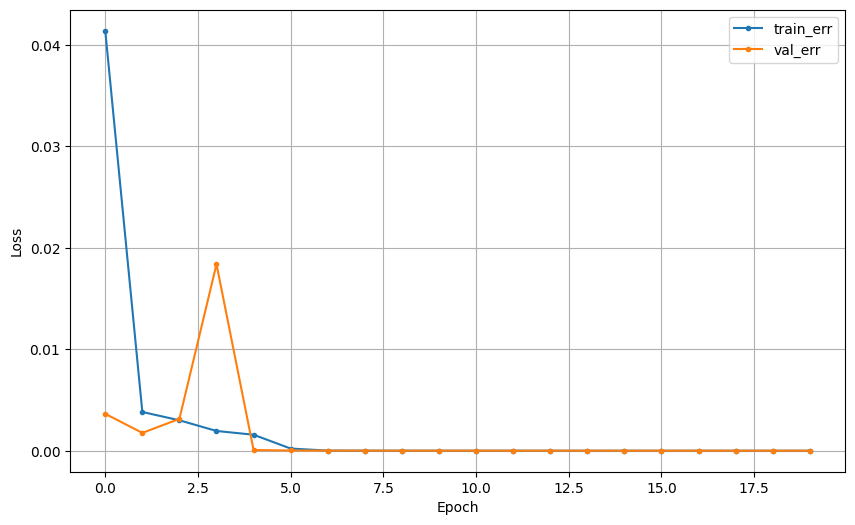

In [76]:
# 학습곡선
dl_history_plot(hist1_1)

In [77]:
# 예측 및 평가
y_pred1_1 = model1_1.predict(val_x_s)
y_pred1_1 = np.where(y_pred1_1 >= 0.5, 1, 0)

print(confusion_matrix(val_y, y_pred1_1))
print(classification_report(val_y, y_pred1_1))
print(accuracy_score(val_y, y_pred1_1))

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
[[646   1]
 [  0 530]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       647
           1       1.00      1.00      1.00       530

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177

0.9991503823279524


#### 2) 모델2

In [22]:
# 모델 설계
clear_session()

nfeatures = x.shape[1]

model1_2 = Sequential([
    Input(shape = (nfeatures, )),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(16, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

model1_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       143,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,649 (733.00 KB)

 Trainable params: 187,649 (733.00 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# 컴파일 및 학습
model1_2.compile(optimizer = Adam(learning_rate = 0.01), loss = 'binary_crossentropy')
hist1_2 = model1_2.fit(train_x_s, train_y, epochs=20, validation_split=0.2, verbose=0).history

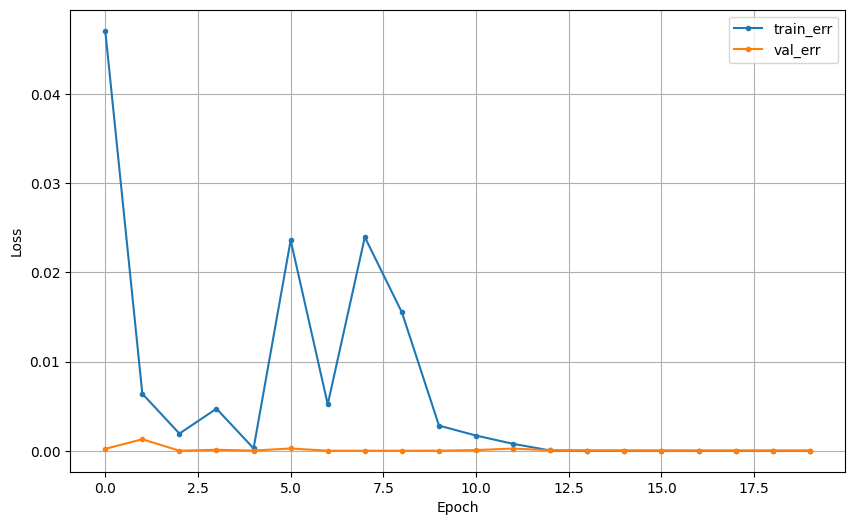

In [24]:
# 학습곡선
dl_history_plot(hist1_2)

In [25]:
# 예측 및 평가
y_pred1_2 = model1_2.predict(val_x_s)
y_pred1_2 = np.where(y_pred1_2 >= 0.5, 1, 0)

print(confusion_matrix(val_y, y_pred1_2))
print(classification_report(val_y, y_pred1_2))
print(accuracy_score(val_y, y_pred1_2))

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
[[646   1]
 [  0 530]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       647
           1       1.00      1.00      1.00       530

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177

0.9991503823279524


### (2) 단계2

#### 1) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [80]:
# (tip) 정적 행동(0)인 데이터 추출
train0 = train[train['Activity'].isin(group0)]
train0

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
7,0.272026,-0.001329,-0.125491,-0.992068,-0.912985,-0.972451,-0.994752,-0.943141,-0.976428,-0.925446,...,-0.704995,-0.024442,0.076332,0.741277,0.729812,-0.817201,0.037746,0.136129,STANDING,0
8,0.284338,0.021956,-0.006925,-0.980153,-0.838394,-0.782357,-0.983683,-0.816199,-0.743923,-0.914011,...,-0.400197,0.021212,-0.009465,-0.282762,0.563343,-0.782072,0.242834,-0.025285,STANDING,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5874,0.257476,-0.413865,0.017374,-0.919666,0.075259,-0.630716,-0.937986,0.176796,-0.613510,-0.866296,...,-0.091605,-0.000793,0.267189,-0.186202,0.098099,0.792970,-0.034020,-0.928148,LAYING,0
5875,0.277378,-0.013298,-0.104322,-0.996596,-0.987491,-0.973345,-0.996372,-0.987746,-0.973512,-0.942156,...,-0.956239,0.122320,0.136275,-0.708377,-0.507788,-0.818263,0.222620,0.035430,STANDING,0
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,SITTING,0
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,LAYING,0


In [81]:
# (tip) 인코딩 진행, map 활용해서 숫자레이블로 매핑
train0['Activity_label'] = train0['Activity'].map({'LAYING' : 0, 'SITTING': 1, 'STANDING': 2})
train0['Activity_label']

/tmp/ipython-input-781237946.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train0['Activity_label'] = train0['Activity'].map({'LAYING' : 0, 'SITTING': 1, 'STANDING': 2})


,Activity_label
0,2
1,0
2,2
7,2
8,2
...,...
5874,0
5875,2
5876,1
5878,0


In [82]:
#x,y 분리하기
x = train0.drop(['Activity', 'is_dynamic', 'Activity_label'], axis = 1)
y1 = train0['is_dynamic']
y2 = train0['Activity_label']

train_x, val_x, train_y, val_y = train_test_split(x, y2, test_size = 0.2, stratify = y2)
print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)

(2587, 561) (2587,)
(647, 561) (647,)


In [83]:
#스케일링 방식을 선택해서 스케일링을 진행합니다.
MM = MinMaxScaler()
train_x_s = MM.fit_transform(train_x)
val_x_s = MM.transform(val_x)

In [84]:
# 모델 설계
clear_session()

nfeatures = x.shape[1]

model2_1 = Sequential([
    Input(shape = (nfeatures, )),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(16, activation = 'relu'),
    Dense(3, activation = 'softmax')
])

model2_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       143,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,683 (733.14 KB)

 Trainable params: 187,683 (733.14 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
# 컴파일 및 학습
model2_1.compile(optimizer = Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=1, restore_best_weights = True)
hist2_1 = model2_1.fit(train_x_s, train_y, epochs=100, validation_split=0.2, callbacks=[es], verbose=1).history

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.8683 - val_loss: 0.3676
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3323 - val_loss: 0.2497
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2336 - val_loss: 0.2256
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1843 - val_loss: 0.1863
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1529 - val_loss: 0.1625
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1396 - val_loss: 0.1628
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1202 - val_loss: 0.1560
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1039 - val_loss: 0.1437
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0953 - val_loss: 0.1241
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0893 - val_loss: 0.1266
Epoch 11/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0796 - val_loss: 0.1293
Epoch 12/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

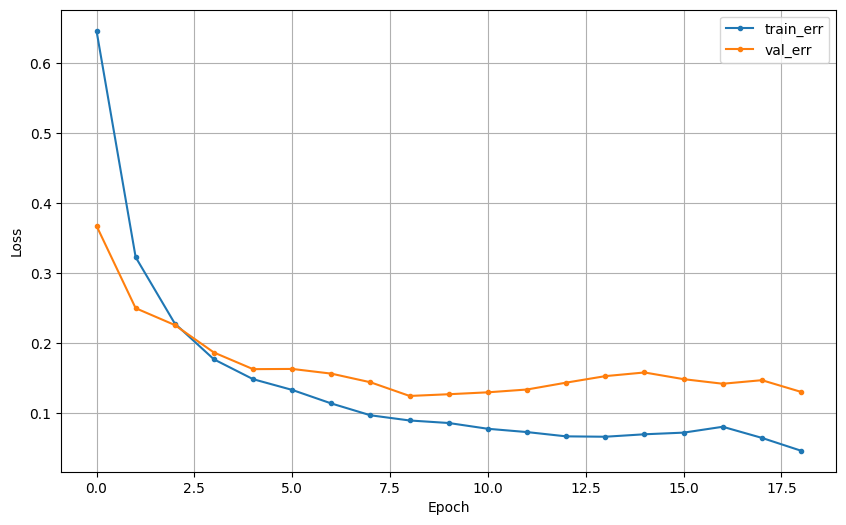

In [86]:
# 학습곡선
dl_history_plot(hist2_1)

In [87]:
# 예측 및 평가
y_pred2_1 = model2_1.predict(val_x_s)
y_pred2_1 = y_pred2_1.argmax(axis = 1)

print(confusion_matrix(val_y, y_pred2_1))
print(classification_report(val_y, y_pred2_1))
print(accuracy_score(val_y, y_pred2_1))

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
[[223   0   0]
 [  0 193  13]
 [  0   8 210]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       0.96      0.94      0.95       206
           2       0.94      0.96      0.95       218

    accuracy                           0.97       647
   macro avg       0.97      0.97      0.97       647
weighted avg       0.97      0.97      0.97       647

0.9675425038639877


#### 2) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [88]:
# (tip) 동적 행동(1)인 데이터 추출
train1 = train[train['Activity'].isin(group1)]
train1

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1
5,0.330708,0.007561,-0.061371,-0.215760,0.101075,0.072949,-0.269857,0.060060,0.101298,-0.019263,...,-0.887024,-0.030645,-0.852091,-0.500195,0.306091,-0.552729,0.253885,0.291256,WALKING_UPSTAIRS,1
6,0.121465,-0.031902,-0.005196,-0.152198,-0.113104,-0.239423,-0.202401,-0.164698,-0.247099,0.114668,...,-0.775779,0.445206,-0.003487,-0.940185,0.041387,-0.886603,0.173338,-0.005627,WALKING,1
12,0.303885,0.002768,-0.038613,-0.168656,0.190336,-0.140473,-0.205134,0.101144,-0.120572,-0.000818,...,-0.329728,-0.040030,0.257252,0.076091,-0.123425,-0.752882,0.266729,0.045692,WALKING,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5868,0.277709,-0.053919,-0.098746,-0.589970,-0.076626,-0.500837,-0.605474,-0.142798,-0.506696,-0.533485,...,-0.268237,-0.076922,0.706620,-0.954969,-0.324779,-0.691663,0.153974,-0.196833,WALKING,1
5869,0.252496,-0.009773,-0.118293,-0.155168,-0.244513,-0.044524,-0.244367,-0.229509,-0.042199,0.291682,...,-0.752980,0.619246,-0.684483,0.924623,-0.353041,-0.775518,0.253218,0.013216,WALKING_UPSTAIRS,1
5873,0.264961,-0.034719,-0.088140,-0.368158,-0.074514,-0.229606,-0.394387,-0.082437,-0.243525,-0.261087,...,-0.046157,0.037517,-0.903692,0.614933,-0.610918,-0.601604,0.335996,0.156518,WALKING,1
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,WALKING_UPSTAIRS,1


In [89]:
# (tip) map 활용해서 숫자레이블로 매핑
train1['Activity_label'] = train1['Activity'].map({'WALKING' : 0, 'WALKING_UPSTAIRS': 1, 'WALKING_DOWNSTAIRS': 2})
train1['Activity_label']

/tmp/ipython-input-3726317993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train1['Activity_label'] = train1['Activity'].map({'WALKING' : 0, 'WALKING_UPSTAIRS': 1, 'WALKING_DOWNSTAIRS': 2})


,Activity_label
3,0
4,2
5,1
6,0
12,0
...,...
5868,0
5869,1
5873,0
5877,1


In [90]:
#x,y 분리하기
x = train1.drop(['Activity', 'is_dynamic', 'Activity_label'], axis = 1)
y1 = train1['is_dynamic']
y2 = train1['Activity_label']

train_x, val_x, train_y, val_y = train_test_split(x, y2, test_size = 0.2, stratify = y2)
print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)

(2117, 561) (2117,)
(530, 561) (530,)


In [91]:
#스케일링 방식을 선택해서 스케일링을 진행합니다.
MM = MinMaxScaler()
train_x_s = MM.fit_transform(train_x)
val_x_s = MM.transform(val_x)

In [92]:
# 모델 설계
clear_session()

nfeatures = x.shape[1]

model2_2 = Sequential([
    Input(shape = (nfeatures, )),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(16, activation = 'relu'),
    Dense(3, activation = 'softmax')
])

model2_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       143,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,683 (733.14 KB)

 Trainable params: 187,683 (733.14 KB)

 Non-trainable params: 0 (0.00 B)

In [93]:
# 컴파일 및 학습
model2_2.compile(optimizer = Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=1, restore_best_weights = True)
hist2_2 = model2_2.fit(train_x_s, train_y, epochs=100, validation_split=0.2, callbacks=[es], verbose=1).history

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.8436 - val_loss: 0.2567
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1838 - val_loss: 0.0841
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0783 - val_loss: 0.0715
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0603 - val_loss: 0.0477
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0229 - val_loss: 0.0888
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0236 - val_loss: 0.1509
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1105 - val_loss: 0.0575
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0252 - val_loss: 0.0381
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0163 - val_loss: 0.0162
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 - val_loss: 0.2263
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0565 - val_loss: 0.0174
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

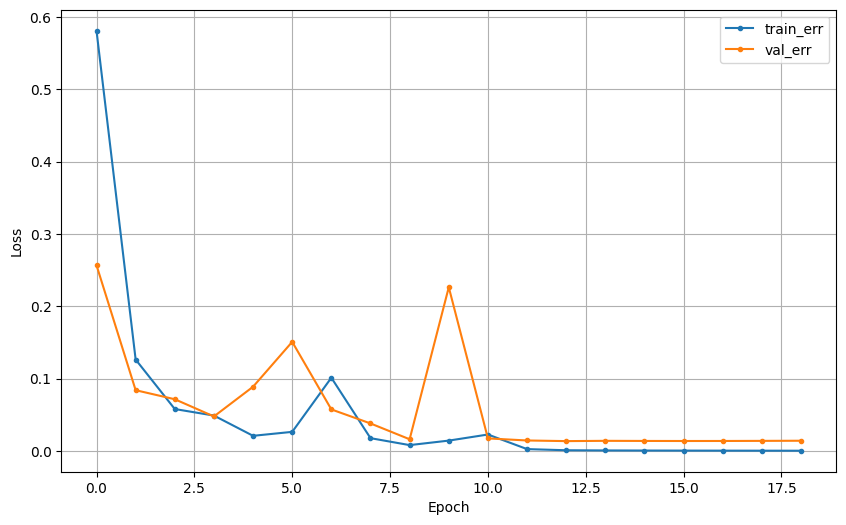

In [94]:
# 학습곡선
dl_history_plot(hist2_2)

In [95]:
# 예측 및 평가
y_pred2_2 = model2_2.predict(val_x_s)
y_pred2_2 = y_pred2_2.argmax(axis = 1)

print(confusion_matrix(val_y, y_pred2_2))
print(classification_report(val_y, y_pred2_2))
print(accuracy_score(val_y, y_pred2_2))

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
[[199   1   0]
 [  0 172   0]
 [  0   1 157]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       200
           1       0.99      1.00      0.99       172
           2       1.00      0.99      1.00       158

    accuracy                           1.00       530
   macro avg       1.00      1.00      1.00       530
weighted avg       1.00      1.00      1.00       530

0.9962264150943396


### (3) (옵션) 분류 모델 파이프라인 구성


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

* 예시
![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [ ]:
#(tip) 함수 만들기
# 1. 전처리
# 1-1. 스케일링
# 1-2. 입력값 만들기
#-------------------
# 2. 예측하기
# 2-1. 단계1을 모델로 0,1 구분
# 2-2. 단계 1의 결과로 데이터 나누기
# 2-3. 단계2 모델로 예측
# 2-4. 예측 결과 원래 값으로 변환
# 2-5. 하나로 합쳐보기
#-------------------
# 3. 최종 성능평가 하기

In [96]:
# (옵션) 위 참고해서 분류모델 파이프라인 만들어보기
def tot_model(data):
  # x, y 분할
  data_x = data.drop('Activity', axis = 1)
  data_y = data['Activity'].map({'LAYING' : 0, 'SITTING': 1, 'STANDING': 2, 'WALKING' : 3, 'WALKING_UPSTAIRS': 4, 'WALKING_DOWNSTAIRS': 5})

  # 스케일링
  data_x_s = MM.transform(data_x)

  # 단계1 모델로 0, 1 구분
  y_pred = model1_1.predict(data_x_s)
  y_pred = np.where(y_pred >= 0.5, 1, 0)

  # 단계1 모델 결과로 데이터 나누기
  idx_0 = np.where(y_pred == 0)[0]
  idx_1 = np.where(y_pred == 1)[0]

  data_x_0 = data_x_s[idx_0]
  data_x_1 = data_x_s[idx_1]

  # 단계2 모델로 세부 분류 예측
  y_pred0 = model2_1.predict(data_x_0)
  y_pred0 = y_pred0.argmax(axis = 1)

  y_pred1 = model2_2.predict(data_x_1)
  y_pred1 = y_pred1.argmax(axis = 1)
  y_pred1 = y_pred1 + 3

  # 하나로 합치기
  final_pred = np.empty(data_x_s.shape[0], dtype=int)
  final_pred[idx_0] = y_pred0
  final_pred[idx_1] = y_pred1

  # 예측 결과 원래 값으로 변환
  label_map_rev = {
    0: 'LAYING',
    1: 'SITTING',
    2: 'STANDING',
    3: 'WALKING',
    4: 'WALKING_UPSTAIRS',
    5: 'WALKING_DOWNSTAIRS'
  }

  # numpy 배열이라면 pd.Series로 감싸서 map 사용
  final_pred_label = pd.Series(final_pred).map(label_map_rev)

  # 최종 성능평가
  print(confusion_matrix(data_y, final_pred))
  print(classification_report(data_y, final_pred))

  return final_pred_label, accuracy_score(data_y, final_pred)

#### 2) test 셋으로 예측하고 평가하기

In [ ]:
# test 셋의 구조 한번 확인해보고 성능평가 해보기

In [97]:
final_pred_label, acc = tot_model(test)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[[292   0   0   0   0   0]
 [ 26 222   6   0   0   0]
 [  0  60 227   0   0   0]
 [  0   2  16 207   3   0]
 [  8  18   5   1 183   0]
 [  1   1   0   0   1 192]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       292
           1       0.73      0.87      0.80       254
           2       0.89      0.79      0.84       287
           3       1.00      0.91      0.95       228
           4       0.98      0.85      0.91       215
           5       1.00      0.98      0.99       195

    accuracy                           0.90      1471
   macro avg       0.92      0.90      0.91      1471
weighted avg       0.91      0.90      0.90      1471



In [98]:
final_pred_label

,0
0,SITTING
1,STANDING
2,WALKING
3,SITTING
4,STANDING
...,...
1466,SITTING
1467,STANDING
1468,WALKING_DOWNSTAIRS
1469,LAYING


In [99]:
acc

0.8993881713120326